# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I have used tools to identify lane lines on the road.  I have developed a pipeline on a series of individual images, and later apply the result to a video stream.

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below to display the image.

---

## Helper Functions

Below are helper functions and processing pipline used for image and video processing.

In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # if lines is not None:
    #     for line in lines:
    #         for x1,y1,x2,y2 in line:
    #             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8
    )
    img = np.copy(img)
    if lines is None:
        return
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    return img

def annotate_lines(img, cropped_img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(cropped_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # weighted_imgage = weighted_img(lines, image, α=0.8, β=1., γ=0.)
    # hough_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
 
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if math.fabs(slope) < 0.5:
                continue
            if slope <= 0:
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else:
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
                
    min_y = int(img.shape[0] * (3 / 5))
    max_y = int(img.shape[0])

    right_x_start = 0
    right_x_end = 0
    left_x_start = 0
    left_x_end = 0


    if len(left_line_x) != 0 or len(left_line_y) != 0:
        poly_left = np.poly1d(np.polyfit(
            left_line_y,
            left_line_x,
            deg=1
        ))
        left_x_start = int(poly_left(max_y))
        left_x_end = int(poly_left(min_y))
 
    if len(right_line_y) != 0 or len(right_line_x) != 0:
        poly_right = np.poly1d(np.polyfit(
            right_line_y,
            right_line_x,
        deg=1
        )) 
        right_x_start = int(poly_right(max_y))
        right_x_end = int(poly_right(min_y))

    line_image = draw_lines(
        img,
        [[
            [left_x_start, max_y, left_x_end, min_y],
            [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness=15,
    )
    return line_image
    
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)



## Build a Lane Finding Pipeline



In [3]:
def process_image(image, kernel_size = 9, 
                        low_threshold = 63, 
                        high_threshold = 158, 
                        rho = 5, 
                        theta_coef=1, 
                        threshold = 84,
                        min_line_length = 197,
                        max_line_gap = 1000):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    grayimg = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(grayimg, kernel_size)

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 330), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # edge_finder = EdgeFinder(masked_edges, kernel_size, low_threshold, high_threshold)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    # rho - distance resolution in pixels of the Hough grid
    theta = theta_coef*np.pi/180 # angular resolution in radians of the Hough grid
    # threshold - minimum number of votes (intersections in Hough grid cell)
    # min_line_length - minimum number of pixels making up a line
    # max_line_gap - maximum gap in pixels between connectable line segments
    lines = annotate_lines(image, masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    plt.imshow(lines)  # if you wanted to show a single color channel image called 'gray', for example, call as          plt.imshow(gray, cmap='gray')

    return lines

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**


challange1.jpg


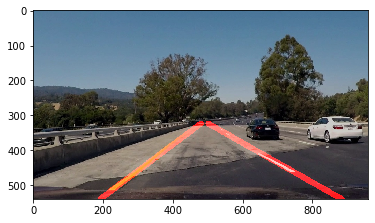


challange2.jpg


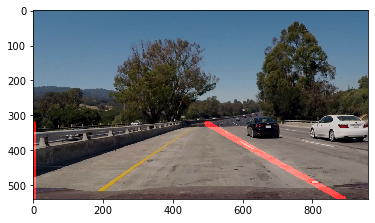


challange3.jpg


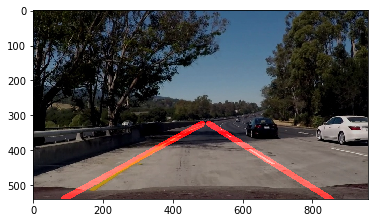


solidWhiteCurve.jpg


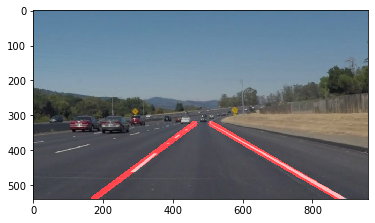


solidWhiteRight.jpg


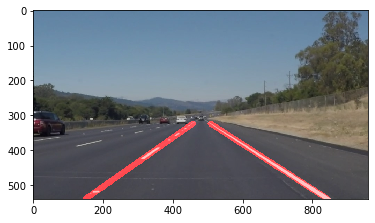


solidYellowCurve.jpg


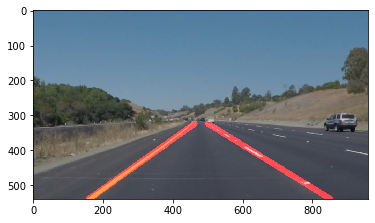


solidYellowCurve2.jpg


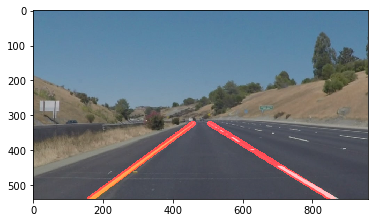


solidYellowLeft.jpg


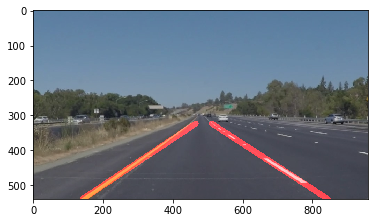


whiteCarLaneSwitch.jpg


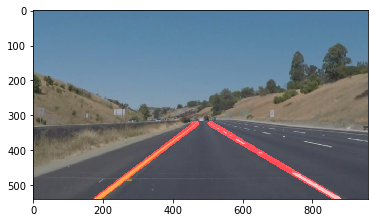

In [4]:
import os

#reading in images
# challange1.jpg
# challange2.jpg
# challange3.jpg
# solidWhiteCurve.jpg
# solidWhiteRight.jpg
# solidYellowCurve.jpg
# solidYellowCurve2.jpg
# solidYellowLeft.jpg
# whiteCarLaneSwitch.jpg

for filename in os.listdir("test_images/"):
    print("\n" + filename)
    if filename != None:
        if filename.endswith(".jpg"):
            image = mpimg.imread("test_images/"+filename)
            process_image(image)
            plt.show()
        else:
            continue

## Test on Videos
 
Below you can find tests for video processing:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

`challenge.mp4`

In [6]:
#import 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

t:   2%|▏         | 5/221 [00:00<00:04, 44.25it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

t:  99%|█████████▉| 219/221 [00:05<00:00, 39.47it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.06 s


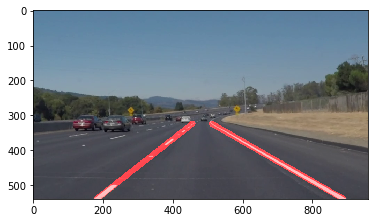

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4').subclip(0,5)
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/solidWhiteRight.mp4">
</video>
""".format(white_output))

t:   1%|          | 5/681 [00:00<00:13, 49.02it/s, now=None]Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

t: 100%|█████████▉| 680/681 [00:18<00:00, 30.38it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 18.9 s


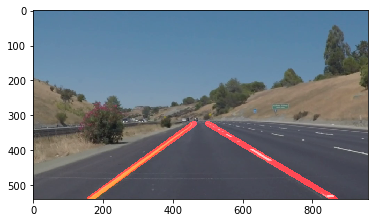

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/solidYellowLeft.mp4">
</video>
""".format(yellow_output))

## Optional Challenge 

Below is test for processing challenge video.

t:   2%|▏         | 4/251 [00:00<00:07, 33.06it/s, now=None]Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

t:  99%|█████████▉| 249/251 [00:10<00:00, 23.74it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 11.7 s


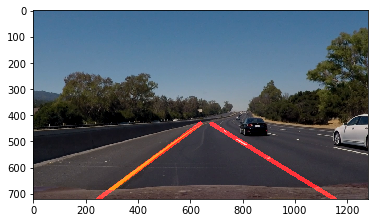

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/challenge.mp4">
</video>
""".format(challenge_output))